# Basic Autoencoders
- Objective: understand basics of autoencoders
- References
    - https://blog.keras.io/building-autoencoders-in-keras.html
    - https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

## Autoencoders
- One of the unsupervised neural network structures to obtain **compressed encodings**
- Mainly used for dimensionality reduction, generative models, denoising etc.

<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png" style="width: 600px"/>
</br>

- Two main components of autoencoder; encoder and decoder
    - Encoder compresses input into small set of "codes" (generally, dimensionality of encoder output is much smaller than encoder input)
    - Decoder then expands the encoder output into output that has same dimensionality as encoder input
    - In other words, autoencoder aims to "reconstruct" the input while learning finite representation of the data (i.e., "codes")

### Load dataset
- Digits dataset in sklearn

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import datasets
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [32]:
data = datasets.load_digits()

In [33]:
X_data = data.images
y_data = data.target

In [34]:
X_data = X_data.reshape(X_data.shape[0], 64)

In [36]:
# fit in data instances into interval [0,1]
X_data = X_data / 16.

In [37]:
X_data[0]

array([ 0.    ,  0.    ,  0.3125,  0.8125,  0.5625,  0.0625,  0.    ,
        0.    ,  0.    ,  0.    ,  0.8125,  0.9375,  0.625 ,  0.9375,
        0.3125,  0.    ,  0.    ,  0.1875,  0.9375,  0.125 ,  0.    ,
        0.6875,  0.5   ,  0.    ,  0.    ,  0.25  ,  0.75  ,  0.    ,
        0.    ,  0.5   ,  0.5   ,  0.    ,  0.    ,  0.3125,  0.5   ,
        0.    ,  0.    ,  0.5625,  0.5   ,  0.    ,  0.    ,  0.25  ,
        0.6875,  0.    ,  0.0625,  0.75  ,  0.4375,  0.    ,  0.    ,
        0.125 ,  0.875 ,  0.3125,  0.625 ,  0.75  ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.375 ,  0.8125,  0.625 ,  0.    ,  0.    ,  0.    ])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = 777)

In [39]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1257, 64)
(540, 64)
(1257,)
(540,)


## Simple autoencoder
- Simple autoencoder with only one hidden layer
- Hence, both encoder and decoder are composed of two layers

In [40]:
# define coding dimension
code_dim = 6

In [54]:
inputs = Input(shape = (X_train.shape[1],), name = 'input')                         # input layer
code = Dense(code_dim, activation = 'relu', name = 'code')(inputs)                  # hidden layer => represents "codes"
outputs = Dense(X_train.shape[1], activation = 'softmax', name = 'output')(code)    # output layer

In [55]:
auto_encoder = Model(inputs = inputs, outputs = outputs)
auto_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64)                0         
_________________________________________________________________
code (Dense)                 (None, 6)                 390       
_________________________________________________________________
output (Dense)               (None, 64)                448       
Total params: 838
Trainable params: 838
Non-trainable params: 0
_________________________________________________________________


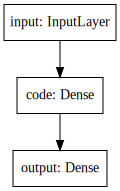

In [56]:
SVG(model_to_dot(auto_encoder).create(prog='dot', format='svg'))

In [57]:
encoder = Model(inputs = inputs, outputs = code)

In [58]:
decoder_input = Input(shape = (code_dim,))
decoder_output = auto_encoder.layers[-1]
decoder = Model(inputs = decoder_input, outputs = decoder_output(decoder_input))

In [59]:
auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')

#### Training the model
- Note that the features and targets are identical (i.e., **X_train**)

In [60]:
%%time
auto_encoder.fit(X_train, X_train, epochs = 1000, batch_size = 50, validation_data = (X_test, X_test), verbose = 0)

Wall time: 1min 28s


In [61]:
encoded = encoder.predict(X_test)
decoded = decoder.predict(encoded)

In [62]:
plt.figure(figsize = (10,4))

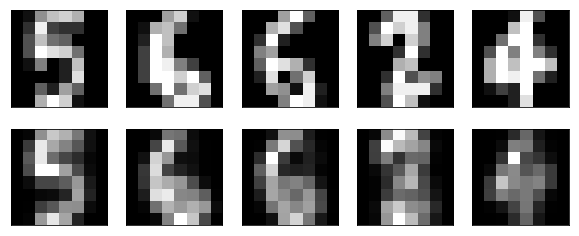

In [63]:
n = 5
for i in range(n):
    # visualizing test data instances
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(8,8))
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # visualizing encode-decoded test data instances
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded[i].reshape(8,8))
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Deep Autoencoder
- Autoencoders can be composed of several layers, i.e., deep autoencoder

<br>

<img src="https://deeplearning4j.org/img/deep_autoencoder.png" style="width: 800px"/>

In [78]:
def encoder_decoder(code_dim = 10):
    inputs = Input(shape = (X_train.shape[1],))
    code = Dense(50, activation= 'relu')(inputs)
    code = Dense(50, activation = 'relu')(code)
    code = Dense(code_dim, activation = 'relu')(code)
    
    outputs = Dense(50, activation = 'relu')(code)
    outputs = Dense(50, activation = 'relu')(outputs)
    outputs = Dense(X_train.shape[1], activation = 'sigmoid')(outputs)
    
    auto_encoder = Model(inputs = inputs, outputs = outputs)
    auto_encoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    
    return auto_encoder

In [80]:
auto_encoder = encoder_decoder()

In [82]:
%%time
auto_encoder.fit(X_train, X_train, epochs = 1000, batch_size = 50, validation_data = (X_test, X_test), verbose = 0)

Wall time: 1min 51s


In [85]:
decoded = auto_encoder.predict(X_test)

In [86]:
plt.figure(figsize = (10,4))

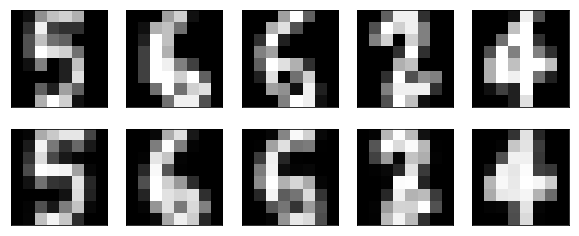

In [87]:
n = 5
for i in range(n):
    # visualizing test data instances
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(8,8))
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # visualizing encode-decoded test data instances
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded[i].reshape(8,8))
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

One can see that deep autoencoder generates results closer to the original data